# Task 2: Credit card detection

- Develop a machine learning model designed to detect fraudulent credit card
transactions.

- The process involves preprocessing and normalizing transaction data, addressing class imbalance concerns, and partitioning the dataset into training and testing subsets.

- Train a classification algorithm—like logistic regression or random forests—to
differentiate between fraudulent and legitimate transactions.

- Assess the model's efficacy using metrics such as precision, recall, and F1-score.

- Additionally, explore strategies like oversampling or undersampling to enhance
outcomes and refine the model's performance.

# Credit Card Fraud Detection Dataset

## Overview
This dataset comprises anonymized credit card transactions, each labeled as either fraudulent or genuine. The primary aim is to facilitate the detection of fraudulent credit card transactions to prevent customers from being charged for unauthorized purchases.

## Context
Credit card companies rely on robust fraud detection mechanisms to safeguard customers from fraudulent transactions. Detecting and preventing fraudulent activities is crucial for maintaining trust and security in financial transactions.

## Content
- The dataset contains credit card transactions made by European cardholders in September 2013.
- Transactions span over two days, with a total of 284,807 transactions.
- Among these transactions, there are 492 instances of fraud.
- The dataset exhibits significant class imbalance, with fraudulent transactions accounting for only 0.172% of the total.
- Features include numerical inputs resulting from a Principal Component Analysis (PCA) transformation. However, due to confidentiality constraints, the original features and additional background information are not provided.
- Features V1 to V28 represent principal components obtained through PCA, while 'Time' and 'Amount' are original features.
- The 'Time' feature denotes the elapsed time in seconds between each transaction and the first transaction in the dataset.
- The 'Amount' feature indicates the transaction amount.
- The response variable, 'Class', takes a value of 1 for fraudulent transactions and 0 otherwise.

## Recommendations
- Given the class imbalance, it's advisable to evaluate model performance using metrics such as the Area Under the Precision-Recall Curve (AUPRC).
- Accuracy metrics derived from a confusion matrix may not be meaningful due to the imbalance in class distribution.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

Retrieving data from Kaggle API, (using local machine)

In [4]:
# Local PC data retrieving
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('mlg-ulb/creditcardfraud', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw/creditcard.csv")

Retrieving data from Kaggle API, (using Google Colab)

In [5]:
# # Google Colab data retrieving
# from google.colab import files

# # Uploading the Kaggle API key (kaggle.json) to Colab
# files.upload()

# # Move the uploaded file to the required location of Colab
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d mlg-ulb/creditcardfraud #dataset download
# !unzip -q creditcardfraud.zip #unzipping the data

# df = pd.read_csv("creditcard.csv") #reading data as pandas dataframe

Separating the dataframe into the slices I will use to analyze the data and undertand it

In [6]:
data_3_principal = df[['Time', 'Amount', 'Class']]
fraudulent_transactions = df[df['Class'] == 1]
not_fraudulent_transactions = df[df['Class'] == 0]

Profile report of the dataset, overview and relationships between Time, Amount and Class variables

In [7]:
pf_3_variables = ProfileReport(data_3_principal)
pf_3_variables.to_file("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/reports/3_variables_report.html")
pf_3_variables

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
pf_fraudulent_trans = ProfileReport(fraudulent_transactions[['Time', 'Amount']])
pf_fraudulent_trans.to_file("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/reports/fraudulent_transactions_report.html")
pf_fraudulent_trans

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA, (Exploratory data analysis)

Information about nulls, infinite values and duplicates on the data

In [9]:
inf_values = np.isinf(df)
inf_rows, inf_cols = np.where(inf_values)

nulls = df.isnull()
null_rows, null_cols = np.where(nulls)

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {df.duplicated().sum()}')

print(f'Rows with null values: {null_rows.sum()}')
print(f'Columns with null values: {null_cols.sum()}')

print(f'Rows with inf values: {inf_rows.sum()}')
print(f'Columns with inf values: {inf_cols.sum()}')

Total of null data: 0
Total of duplicated data: 1081
Rows with null values: 0
Columns with null values: 0
Rows with inf values: 0
Columns with inf values: 0


Duplicates treatment, four percent of the data of Class1 are duplicate rows so I decide to eliminate all those rows to not interfere in the following analysis and ML model

In [10]:
duplicated_rows = df.duplicated()
duplicated_class_1_rows = duplicated_rows & (df['Class'] == 1)

print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')
print(f'Total duplicates of the Class 1: {duplicated_class_1_rows.sum()}')
print(f'Percentage of duplicates of Class 1: {duplicated_class_1_rows.sum() / df["Class"].sum() * 100:.1f}%')

# Eliminating duplicated data
df = df.copy().drop_duplicates()

Percentage of total duplicated data: 0.4%
Total duplicates of the Class 1: 19
Percentage of duplicates of Class 1: 3.9%


In [11]:
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

In [12]:
percentage_data_by_class = df['Class'].value_counts(normalize=True)
print(f'Percentage of data by class: \n{percentage_data_by_class}')

Percentage of data by class: 
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [13]:
# Full distribution analysis
from scipy import stats
def calculate_stats(data: pd.DataFrame) -> list:
    """
    Calculate the mean, standard deviation, skewness, and kurtosis for each column in a DataFrame.

    Parameters:
    data (pd.DataFrame): The DataFrame for which to calculate statistics.

    Returns:
    mean (list): The mean of each column.
    std (list): The standard deviation of each column.
    skewness (list): The skewness of each column.
    kurtosis (list): The kurtosis of each column.
    """

    # Initialize lists to store results
    mean, std, skewness, kurtosis = [], [], [], []

    for column in data.columns:
        mean.append(data[column].mean())
        std.append(data[column].std())
        skewness.append(stats.skew(data[column]))
        kurtosis.append(stats.kurtosis(data[column]))

    # Return the calculated statistics
    return mean, std, skewness, kurtosis


#Usage of the function in the original data
mean, std, skewness, kurtosis = calculate_stats(df)

stats_data = pd.DataFrame({'Column': df.columns,
                         'Mean': mean,
                         'Std': std,
                         'Skewness': skewness,
                         'Kurtosis': kurtosis})
stats_data

,Column,Mean,Std,Skewness,Kurtosis
0,Time,94811.077600,47481.047891,-0.035580,-1.293431
1,V1,0.005917,1.948026,-3.273254,32.726735
2,V2,-0.004135,1.646703,-4.695137,96.896444
3,V3,0.001613,1.508682,-2.151973,25.186065
4,V4,-0.002966,1.414184,0.671501,2.618712
5,V5,0.001828,1.377008,-2.414066,209.273758
6,V6,-0.001139,1.331931,1.829871,42.838110
7,V7,0.001801,1.227664,2.890256,414.134868
8,V8,-0.000854,1.179054,-8.310926,215.013122
9,V9,-0.001596,1.095492,0.537660,3.516578


There are not correlations between variables grater or equal than 0.7, but there is one grater or equal than 0.5, which is between `Amount` and `V2`. Therefore when we apply the fueature importance part, the correlations now make more sense and there are many variables correlated, we will see it in further cells.

In [14]:
corr = df.corr()

# Filtering correlations
high_corr_variables = set()
correlation_value = 0.5
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= correlation_value:
            high_corr_variables.add(corr.columns[i])
            high_corr_variables.add(corr.columns[j])

print(f"Variables with a correlation greater than {correlation_value}:")
print(high_corr_variables)

Variables with a correlation greater than 0.5:
{'Amount', 'V2'}


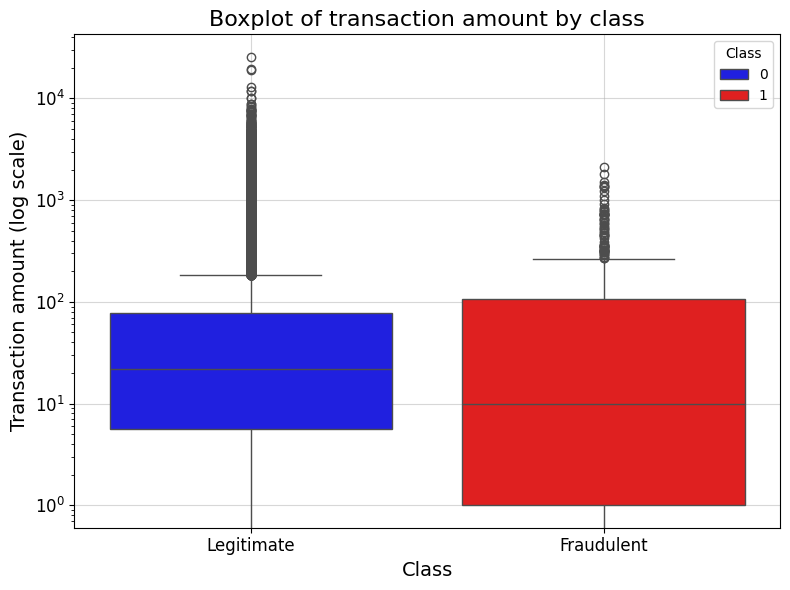

In [15]:
# Distribution of the 'Amount' feature
plt.figure(figsize=(8, 6))

# Create the boxplot with distinct colors for each class
sns.boxplot(x='Class', y='Amount', data=df, hue='Class', palette=['blue', 'red'])

# Add labels and title
plt.title('Boxplot of transaction amount by class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Transaction amount (log scale)', fontsize=14)
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], fontsize=12)
plt.yticks(fontsize=12)

plt.yscale('log') # Use a log scale for the y-axis
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

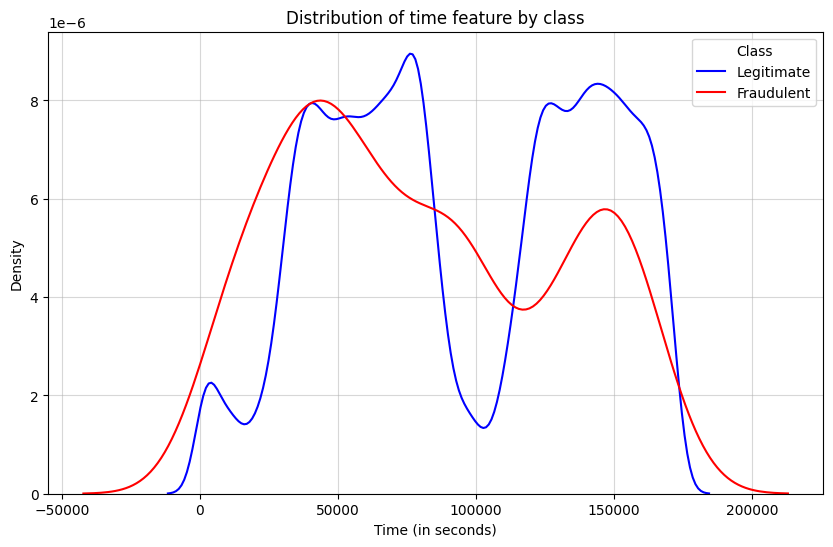

In [16]:
# Density plots for the 'Time' feature by class
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df['Class'] == 0]['Time'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Time'], color='red', label='Fraudulent')

# Add labels and title
plt.xlabel('Time (in seconds)')
plt.ylabel('Density')
plt.title('Distribution of time feature by class')
plt.legend(title='Class')
plt.grid(True, alpha=0.5)

plt.show()

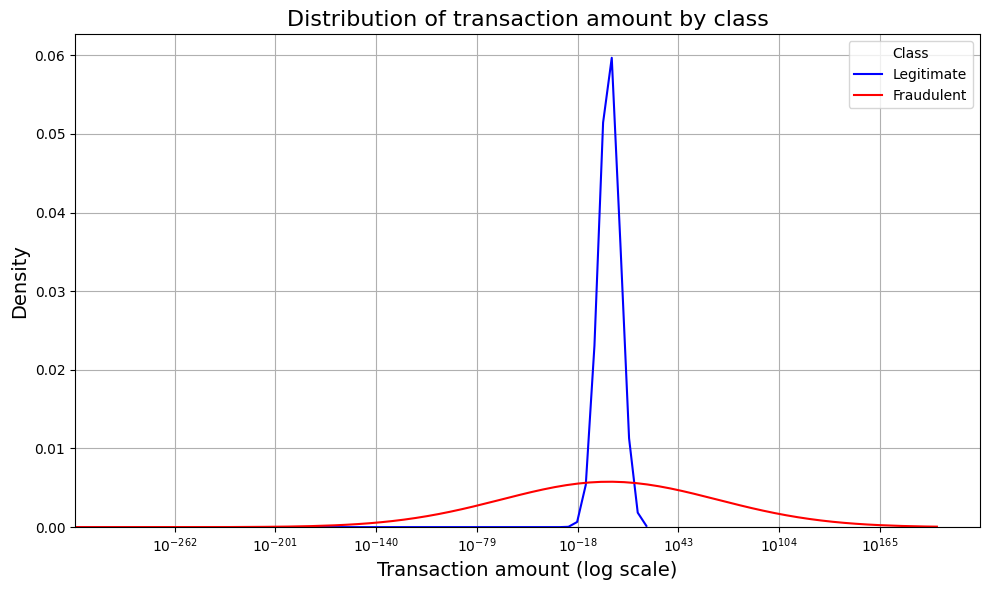

In [17]:
plt.figure(figsize=(10, 6))

plt.xscale('log') # Use a log scale for the y-axis
# Use density plots instead of histograms
sns.kdeplot(df[df['Class'] == 0]['Amount'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Amount'], color='red', label='Fraudulent')

# Add a grid
plt.grid(True)

# Add labels and title
plt.title('Distribution of transaction amount by class', fontsize=16)
plt.xlabel('Transaction amount (log scale)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class')

plt.tight_layout()
plt.show()

Imbalaced data traetment, (three different methods)

In [32]:
from imblearn.over_sampling import SMOTE

def handle_imbalanced_data(dataset: pd.DataFrame, method: str='over_sampling'):
    """
    Handle imbalanced data in a dataset.

    Parameters:
    dataset (DataFrame): The input dataset which is imbalanced.
    method (str): The method to handle imbalanced data. It can be 'over_sampling', 'under_sampling', 'smote'. Default is 'over_sampling'.

    Returns:
    DataFrame: The balanced dataset.
    """
    # Get the counts of each class
    count_class_0, count_class_1 = dataset.Class.value_counts()

    # Divide the dataset by class
    df_class_0 = dataset[dataset['Class'] == 0]
    df_class_1 = dataset[dataset['Class'] == 1]

    # Oversampling: Oversample 1-class and concat the DataFrames of both classes
    if method == 'over_sampling':
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        return pd.concat([df_class_0, df_class_1_over], axis=0)

    # Undersampling: Undersample 0-class and concat the DataFrames of both classes
    elif method == 'under_sampling':
        df_class_0_under = df_class_0.sample(count_class_1)
        return pd.concat([df_class_0_under, df_class_1], axis=0)

    # SMOTE: Use SMOTE to oversample the minority class
    elif method == 'smote':
        smote = SMOTE(random_state=42)
        X_sm, y_sm = smote.fit_resample(dataset.drop('Class', axis=1), dataset['Class'])
        return pd.concat([X_sm, y_sm], axis=1)

    # Method 4, Use of Ensemble with undersampling: Not implemented
    # ...
    else:
        raise ValueError("Invalid method. It should be 'over_sampling', 'under_sampling', 'smote' ... ")

In [33]:
for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df, method=method)
    print(f'Balanced data using {method} method: \n{balanced_data.Class.value_counts()}\n')

Balanced data using over_sampling method: 
Class
0    283253
1    283253
Name: count, dtype: int64

Balanced data using under_sampling method: 
Class
0    473
1    473
Name: count, dtype: int64

Balanced data using smote method: 
Class
0    283253
1    283253
Name: count, dtype: int64



Normalization of the data, I choose RobustScaler since the data I'm dealing with is full of outliers

In [34]:
from sklearn.preprocessing import RobustScaler

# Initialize the scaler
scaler = RobustScaler()

# Scale the 'Amount' and 'Time' columns and drop its original columns
df_scaled = df.copy()
df_scaled[['Amount_normalized', 'Time_normalized']] = scaler.fit_transform(df[['Amount', 'Time']])

df_scaled.drop(['Amount', 'Time'], axis=1, inplace=True)
df_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_normalized,Time_normalized
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,0.001667,0.924387,0.118912
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,0.040796,3.482123,0.557988
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,-0.305938,-0.995290
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,0.000000,-0.228063,-0.358286
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,0.000000,0.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,0.000000,0.771937,0.641714
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000,356.962314,1.035329


In [43]:
from sklearn.metrics import classification_report
# ############################ TESTING ############################
# best_params = {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

# # # Model to train
# # model = RandomForestClassifier(**best_params)

# # # Perform training for each model
# # for method in ['over_sampling', 'under_sampling', 'smote']:
# #     balanced_data = handle_imbalanced_data(df_scaled, method=method)
# #     X = balanced_data.drop('Class', axis=1)
# #     y = balanced_data['Class']
# #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# #     model.fit(X_train, y_train)
# #     y_pred = model.predict(X_test)
# #     print(f"Classification report for {method} and {model.__class__.__name__}: \n{classification_report(y_test, y_pred)}")
# #     print('\n')

As there are highly correlated variables, I can assure that there can be made a feature importance technique for dimensionality reduction in the dataset

Text(0.5, 1.0, 'Correlation Heatmap')

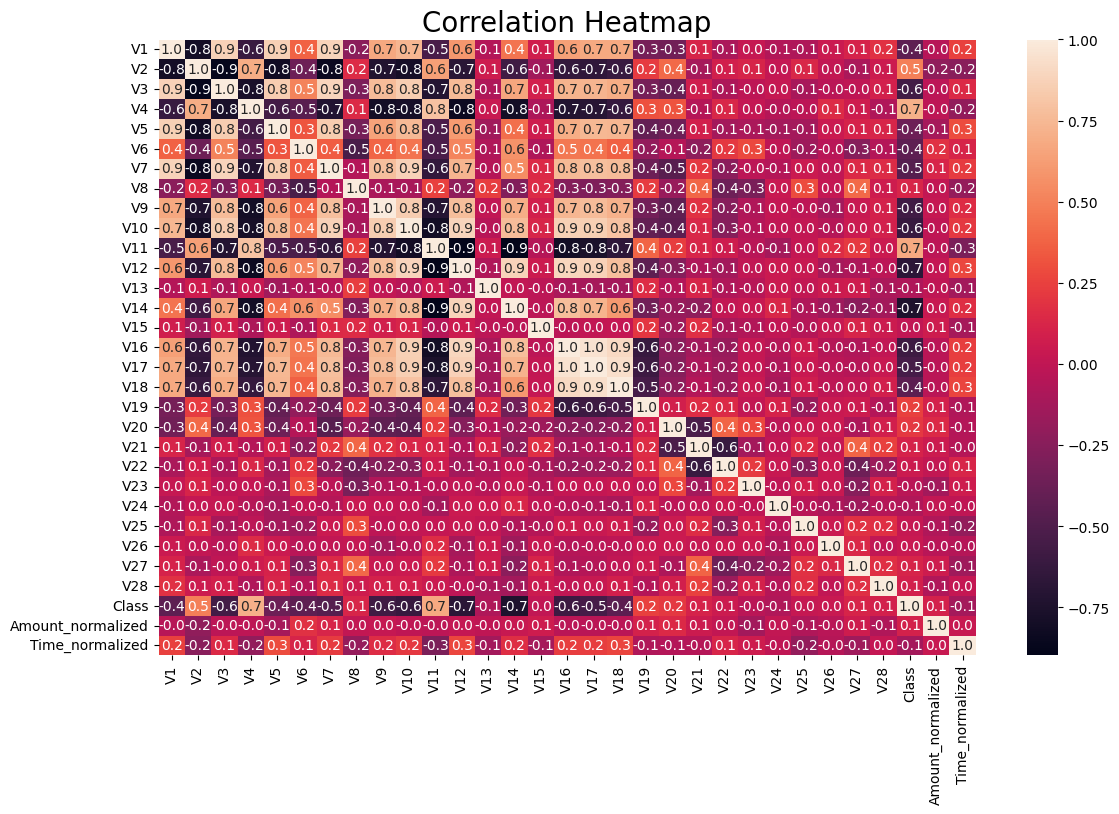

In [44]:
balanced_data = handle_imbalanced_data(df_scaled, method='under_sampling')
X = balanced_data.drop('Class', axis=1)
y = balanced_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Compute the correlation matrix
corr_under_sampling = balanced_data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_under_sampling, annot=True, fmt=".1f")
plt.tight_layout()

plt.title('Correlation Heatmap', fontsize=20)

In [45]:
# from sklearn.model_selection import GridSearchCV

# # Defining the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [1, 3, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_ # best parameters of the search

# # Train the model and predict using the best parameters
# best_model = RandomForestClassifier(**best_params)
# best_model.fit(X_train, y_train)

# y_pred = best_model.predict(X_test)

# # Print the metrics
# print(f"Classification report for {best_model.__class__.__name__}: \n{classification_report(y_test, y_pred)}")
# print('Best params:', best_params)

In [46]:
############################ TESTING ############################
best_params = {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

In [47]:
from sklearn.metrics import accuracy_score

# Train the model and predict using the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = best_model.predict(X_train)

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the metrics
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

print(f"Classification report for {best_model.__class__.__name__}: \n{classification_report(y_test, y_test_pred)}")
print('Best params:', best_params)

Train Accuracy: 0.9561933534743202
Test Accuracy: 0.954225352112676
Classification report for RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       140
           1       0.99      0.92      0.95       144

    accuracy                           0.95       284
   macro avg       0.96      0.95      0.95       284
weighted avg       0.96      0.95      0.95       284

Best params: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


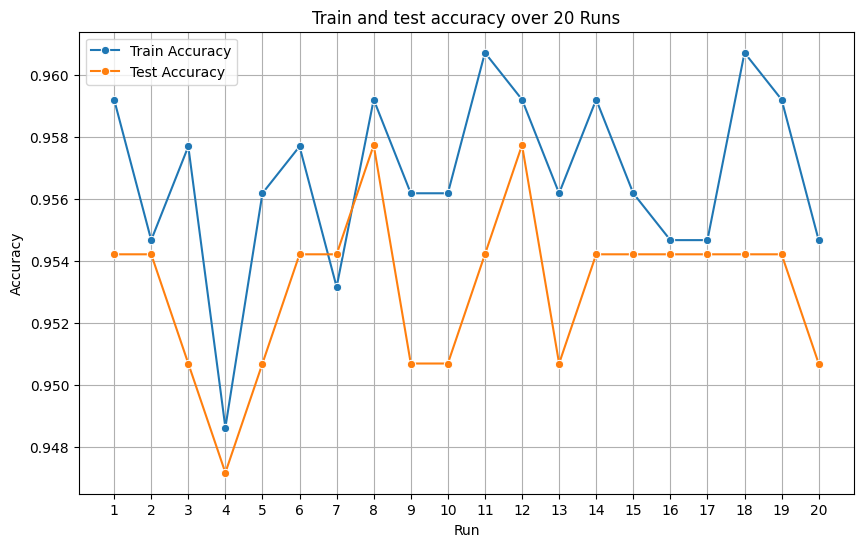

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

for i in range(20):
    # Training the model and predicting using the best parameters
    best_model = RandomForestClassifier(**best_params, random_state=i)
    best_model.fit(X_train, y_train)

    # Predict on the training and testing set
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracy on the training and testing set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 21), y=train_accuracies, marker='o', label='Train Accuracy')
sns.lineplot(x=range(1, 21), y=test_accuracies, marker='o', label='Test Accuracy')
plt.title('Train and test accuracy over 20 Runs')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

Training the model after feaure important technique to reduce dimensionality

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest to the data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances}) # Dataframe of importances
feature_importances = feature_importances.sort_values('importance', ascending=False) # sorting data

In [50]:
# Select the features with more than 3 significant decimals
top_features = feature_importances['feature'][feature_importances['importance'] > 10e-3]
print(top_features)

# Reduce X to the selected features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

13    V14
3      V4
9     V10
16    V17
2      V3
11    V12
10    V11
15    V16
6      V7
1      V2
20    V21
25    V26
18    V19
22    V23
8      V9
7      V8
5      V6
26    V27
Name: feature, dtype: object


In [51]:
# Training model after feature selection
rf_reduced = RandomForestClassifier(random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred_reduced = rf_reduced.predict(X_test_reduced)

# Print the metrics
print(f"Classification report for {rf_reduced.__class__.__name__}: \n{classification_report(y_test, y_pred_reduced)}")

# Accuracy of the model and overfitting analysis
train_accuracy_reduced = accuracy_score(y_train, rf_reduced.predict(X_train_reduced))
test_accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print(f"Train Accuracy: {train_accuracy_reduced}")
print(f"Test Accuracy: {test_accuracy_reduced}")

Classification report for RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       140
           1       0.99      0.92      0.96       144

    accuracy                           0.96       284
   macro avg       0.96      0.96      0.96       284
weighted avg       0.96      0.96      0.96       284

Train Accuracy: 1.0
Test Accuracy: 0.9577464788732394


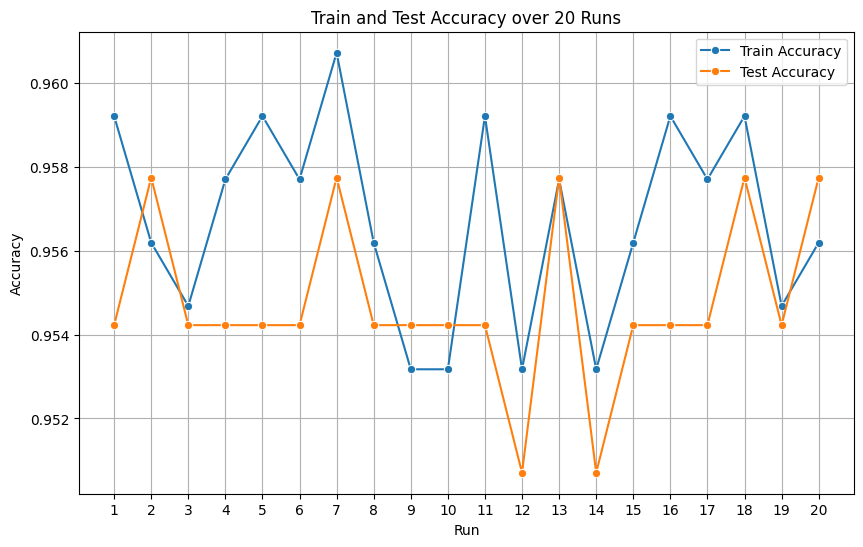

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Run the model 20 times
for i in range(20):
    rf_reduced = RandomForestClassifier(random_state=i, **best_params)
    rf_reduced.fit(X_train_reduced, y_train)

    # Accuracy of the model and overfitting analysis
    train_accuracy_reduced = accuracy_score(y_train, rf_reduced.predict(X_train_reduced))
    test_accuracy_reduced = accuracy_score(y_test, rf_reduced.predict(X_test_reduced))

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy_reduced)
    test_accuracies.append(test_accuracy_reduced)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 21), y=train_accuracies, marker='o', label='Train Accuracy')
sns.lineplot(x=range(1, 21), y=test_accuracies, marker='o', label='Test Accuracy')
plt.title('Train and Test Accuracy over 20 Runs')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()